In [2]:
using HallThruster
using Unitful

# Units will be correctly converted!
# Setting up geometry for my Hall Thruster name "HonestJohn"
my_geometry = HallThruster.Geometry1D(
    inner_radius = 1.2u"cm",
    outer_radius = 3.0u"cm",
    channel_length = 2.0u"cm"
)

HallThruster.Geometry1D(0.02, 0.012, 0.03, 0.0023750440461138833)

In [3]:
# Setting up gradient for the magnetic field
function my_magnetic_field(z)
    if z < 0.03
        return 0.02 * exp(-((z - 0.03) / 0.02)^2)
    else
        return 0.02 * exp(-((z - 0.03) / 0.04)^2)
    end
end

my_magnetic_field (generic function with 1 method)

In [4]:
# Defining the thruster with the magnitic field and geometry described above as well as no shielding
my_thruster = HallThruster.Thruster(
	name = "Honest John",
    magnetic_field = my_magnetic_field,
    geometry = my_geometry,
    shielded = false,
)

HallThruster.Thruster{typeof(my_magnetic_field)}("Honest John", HallThruster.Geometry1D(0.02, 0.012, 0.03, 0.0023750440461138833), my_magnetic_field, false)

In [84]:
# Configuring Thruster
my_config = HallThruster.Config(

     # Voltage between Anode and Cathode
    discharge_voltage = 100u"V",
    
    # Number of charge states to simulate. 
    ncharge = 2,
    # Thruster to be used in simulations (defined above)
    thruster = my_thruster,
    # Size of an area to simulate (since this is 1D simulation we can only simulate )
    domain = (0.0u"cm", 8.0u"cm"),
    # Shows how fast propellant is ingested in anode region (I have conducted a small experiment to verify the flow rate)
    anode_mass_flow_rate = 8u"mg/s",
    # I used pre-defined propellant due to the lack of time
    propellant = Krypton,
    
    # Some of the parameters I used from Tutorial
    wall_loss_model = HallThruster.WallSheath(HallThruster.BoronNitride),
    anom_model = HallThruster.MultiLogBohm([0.02, 0.03, 0.04, 0.06, 0.003, 0.2]),
    neutral_velocity = 500.0u"m/s",
    neutral_temperature = 500.0u"K",
    ion_temperature = 500.0u"K",
    cathode_Te = 2.5u"eV",
    anode_Te = 2.5u"eV",
    ion_wall_losses = true,
)

HallThruster.Config{HallThruster.MultiLogBohm, HallThruster.WallSheath, HallThruster.IonizationLookup, HallThruster.ExcitationLookup, HallThruster.ElectronNeutralLookup, HallThruster.Thruster{typeof(my_magnetic_field)}, Vector{Returns{Float64}}, Vector{Returns{Float64}}, Vector{Returns{Float64}}, Returns{Float64}, Returns{Float64}, HallThruster.LinearTransition, HallThruster.DefaultInitialization, Nothing, HallThruster.HyperbolicScheme{typeof(HallThruster.rusanov), HallThruster.var"#22#23"}}(100.0, 0.0, 2.5, 2.5, HallThruster.WallSheath(HallThruster.WallMaterial("Boron Nitride", 45.0, 0.24), 0.15), 500.0, 500.0, 1.0, Krypton, 2, 500.0, HallThruster.MultiLogBohm([0.02, 0.03, 0.04], [0.06, 0.003, 0.2]), HallThruster.IonizationLookup(String[]), HallThruster.ExcitationLookup(String[]), HallThruster.ElectronNeutralLookup(String[]), true, 0.0, 1.0e6, 2.5, HallThruster.LinearTransition(0.004, 0.0), HallThruster.DefaultInitialization(), nothing, 1.0, Returns{Float64}[Returns{Float64}(0.0)], Re

In [85]:
# Performing simulation - generating data and writing it into my_solutions class
@time my_solution = HallThruster.run_simulation(my_config; grid= EvenGrid(150), nsave=10000, dt=1e-8, duration=1e-3)


Simulation exited at t = 0.001 with retcode :success in 14.957948667 seconds.
 14.958868 seconds (2.16 M allocations: 591.159 MiB, 14.04% gc time)


Hall thruster solution with 10000 saved frames
Retcode: success
End time: 0.001 seconds

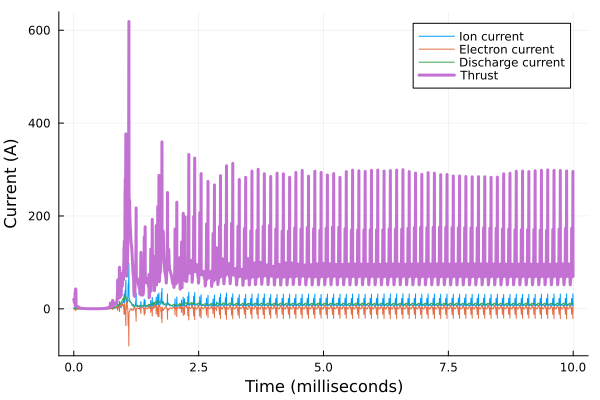

In [86]:
using Plots

# creating a plot for Ion Current, Discharge Current and Electron Current as well as the Thrust - one of the examples used
time_us = my_solution.t .* 1_000_0 # Convert time from seconds to microseconds
I_ion = HallThruster.ion_current(my_solution)
I_total = HallThruster.discharge_current(my_solution)
I_electron = I_total .- I_ion # we can also just type electron_current(my_solution)
thrust_mN = HallThruster.thrust(my_solution) .* 1000

p = plot(
    time_us, I_ion;
    label = "Ion current",
    xlabel = "Time (milliseconds)",
	ylabel = "Current (A)"
)
plot!(p, time_us, I_electron; label = "Electron current")
plot!(p, time_us, I_total; label = "Discharge current")
plot!(p, time_us, thrust_mN; label = "Thrust", linewidth = 3)

display(p)


In [87]:
using Statistics
# Calculating mean Thrust to compare with the manual estimates
return mean(HallThruster.thrust(my_solution)) * 1000

81.87074047786021

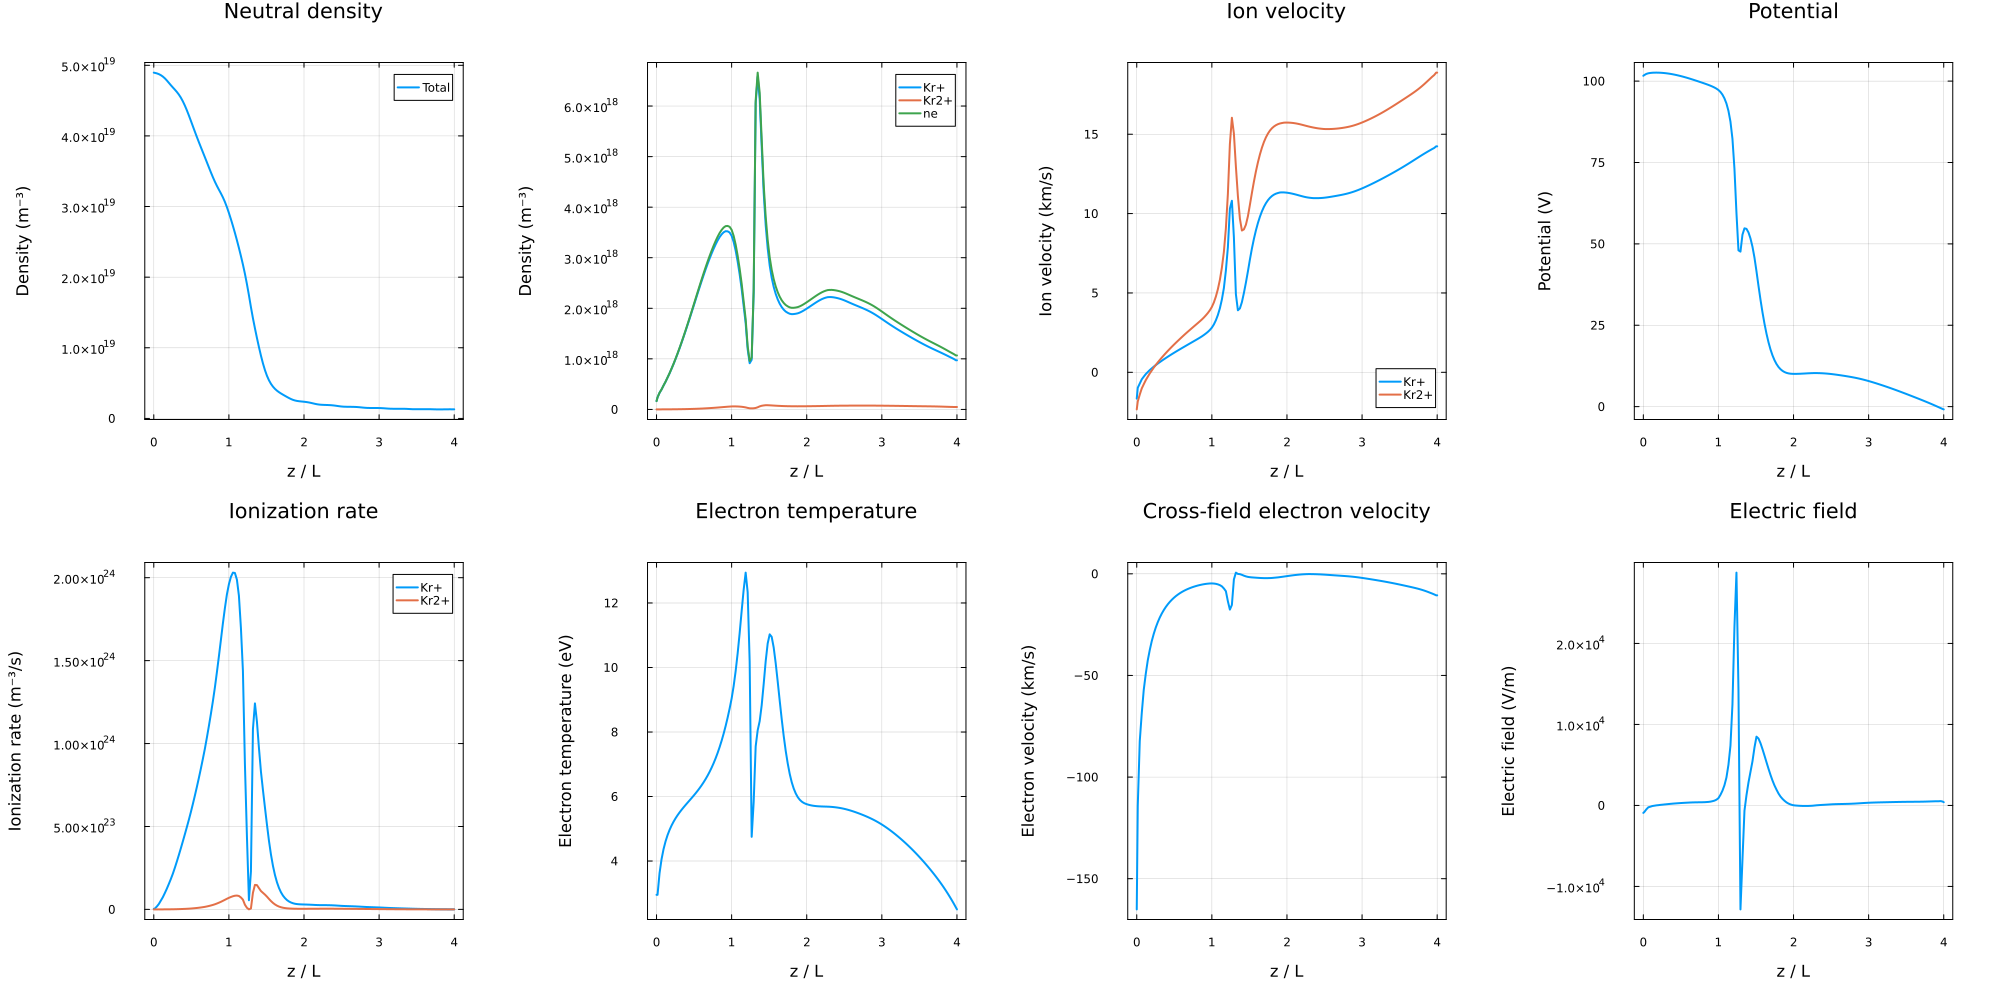

In [88]:
# Plotting all other parameters of the solution
# I am not including this into document itself - leaving here for completeness
plot(my_solution)